In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install tensorflow keras matplotlib


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data directories
train_dir = '/content/drive/MyDrive/cars_train'
val_dir = '/content/drive/MyDrive/cars_test'
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

#Loading and Preprocessing the Training Data:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#Loading and Preprocessing the Validation Data:
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8144 images belonging to 1 classes.
Found 3550 images belonging to 1 classes.


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pretrained VGG16 model without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_data=val_data,
    validation_steps=val_data.samples // BATCH_SIZE,
    epochs=1
)

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")

In [8]:
model.save('vehicle_classifier_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


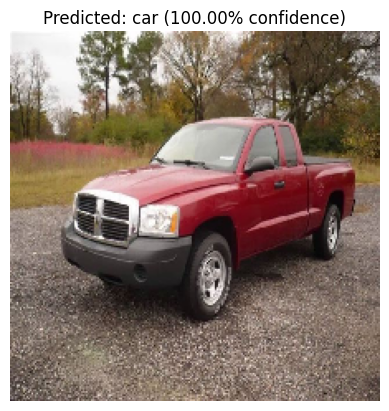

Prediction probabilities: [1.]
The predicted vehicle type is: car


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('vehicle_classifier_model.h5')  # Replace with your actual model path

# Define image dimensions based on your model's expected input size
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Define class names based on your training data (replace with your actual class names)
class_names = {0: 'car', 1: 'truck', 2: 'bus', 3: 'motorbike', 4: 'bicycle', 5: 'jeep'}  # Example class mapping

# Load and preprocess the image
def classify_vehicle_image(img_path):
    # Load image and resize it to the expected input size
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Convert image to array and expand dimensions to match model's input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict the class of the image
    predictions = model.predict(img_array)

    # Get the predicted class and its confidence
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names.get(predicted_class, "Unknown")
    prediction_confidence = predictions[0][predicted_class]

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} ({prediction_confidence*100:.2f}% confidence)")
    plt.axis('off')
    plt.show()

    print(f"Prediction probabilities: {predictions[0]}")
    return predicted_class_name

# Example usage
img_path = '/content/drive/MyDrive/cars_train/cars_train/00003.jpg'
predicted_class = classify_vehicle_image(img_path)
print(f"The predicted vehicle type is: {predicted_class}")
